In [3]:
import numpy as np
import scipy as sp
from scipy.sparse.linalg import expm
import matplotlib.pyplot as plt
import evolve.fourier as fe

# The Grid

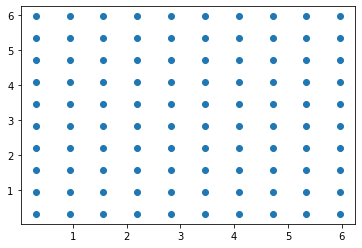

In [4]:
xrange = [0, 2*np.pi]
[x,y] = fe.grid([10,10], xrange)
plt.scatter(x,y)
plt.show()

# Testing differentiation

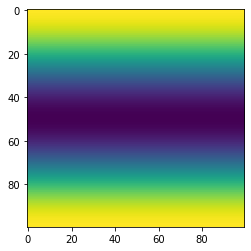

In [5]:
xrange = [0, 2*np.pi]
n = 100
[x,y] = fe.grid([n,n], xrange)
s = np.sin(x)
ds = fe.diffop(0,1,s,xrange)   
d2s = fe.diffop(0,2,s,xrange)  

plt.imshow(np.real(ds))
plt.show()

# Solving the Schrödinger equation

2D Grid

In [6]:
n = [100,100]
xr = [-10, 10]
[x,y] = fe.grid(n, xr)

Initial Condition

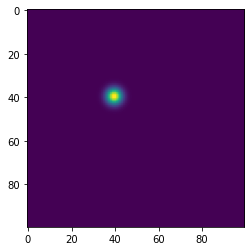

In [7]:
x0 = -2.0
y0 = -2.0
u = np.exp(-((x-x0)**2+(y-y0)**2)/(2*0.25))

plt.imshow(abs(u))
plt.show()

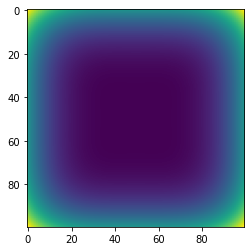

In [8]:
V = x**4 + y**4 - 5*x**2 - 5*y**2
plt.imshow(V)
plt.show()

### Single step of Strang

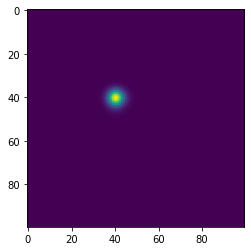

In [9]:
eL1u = lambda h, u: fe.diffopexp(0, 2, 1j*h, u, xr) 
eL2u = lambda h, u: fe.diffopexp(1, 2, 1j*h, u, xr)
eLu = lambda h, u: eL1u(h, eL2u(h, u))

eVu = lambda h, u: np.exp(-1j*h*V)*u
strang = lambda h, u: eVu(h/2, eLu(h, eVu(h/2, u)))


dt = 0.1

ustrang = strang(dt, u)

plt.imshow(np.abs(ustrang))
plt.show()

### Full run of Strang

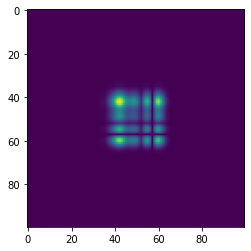

In [10]:
def runstrang(T, N, u0):
    u = u0
    h = T/N
    for i in range(N):
        u = strang(h, u)
    return u

T = 1

ustrangT = runstrang(T,1000,u)
plt.imshow(np.abs(ustrangT))
plt.show()